In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import random
import json
import cv2
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.models import Sequential,Model
from keras.optimizers import Adam,SGD
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, Input, Dropout
from keras.utils import np_utils
from keras import backend as K


2025-08-18 20:00:32.149035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755547232.161351       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755547232.165222       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 20:00:32.180802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'np_utils' from 'keras.utils' (/usr/local/lib/python3.11/dist-packages/keras/api/utils/__init__.py)

In [3]:
path = '../input/aerial-cactus-identification/'
train = pd.read_csv(path + 'train.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')


In [4]:
train.head()


,id,has_cactus
0,2de8f189f1dce439766637e75df0ee27.jpg,1
1,36704d250f236238e7f996812c48235d.jpg,1
2,eacde22fdc8c175972a5768e3daa8bc9.jpg,1
3,5d442f834da5e57d22b24802c32a8ca8.jpg,1
4,152491e0daf75c0e669400300ff7e645.jpg,1


<Axes: xlabel='has_cactus'>

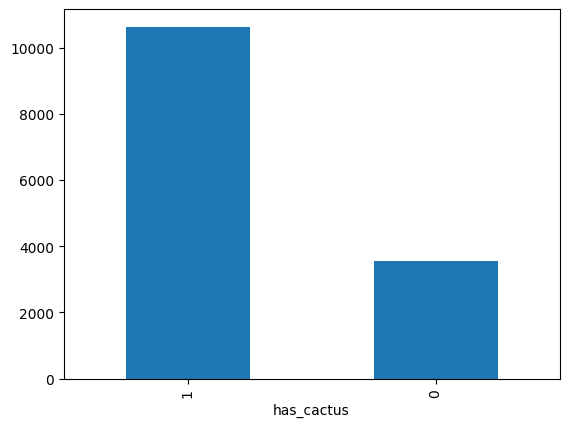

In [5]:
train['has_cactus'].value_counts().plot(kind='bar')


FileNotFoundError: [Errno 2] No such file or directory: '../input/aerial-cactus-identification/train/train/2de8f189f1dce439766637e75df0ee27.jpg'

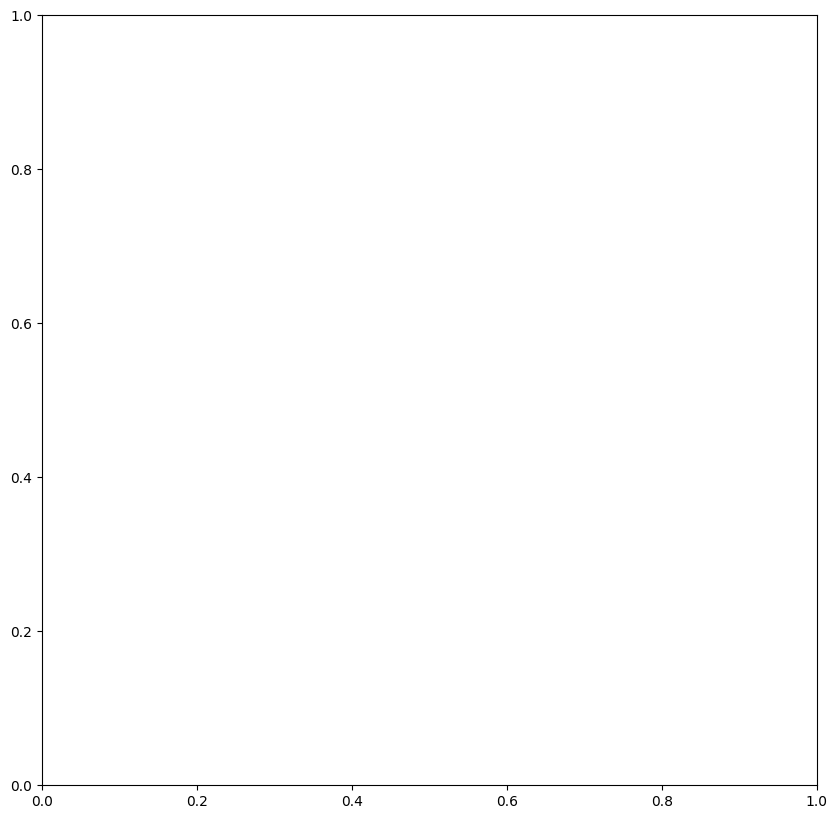

In [6]:
plt.subplots(figsize=(10,10))
for i in range(5):
    img_name = train['id'][i]
    img = Image.open(path + 'train/train/' + img_name)
    plt.imshow(np.asarray(img))
    plt.show()


In [7]:
images = []
labels = []
for i in os.listdir(path + 'train/train/'):
    img = image.load_img(path + 'train/train/' + i, target_size=(32,32))
    img = image.img_to_array(img)
    labels.append(train[train['id'] == i]['has_cactus'].values[0])
    images.append(img)


FileNotFoundError: [Errno 2] No such file or directory: '../input/aerial-cactus-identification/train/train/'

In [8]:
combined = list(zip(images,labels))
random.shuffle(combined)
images[:],labels[:] = zip(*combined) 


ValueError: not enough values to unpack (expected 2, got 0)

In [9]:
X_train = np.asarray(images)
X_train = X_train.astype('float32')
X_train /= 255
y_train = np.array(labels)


In [10]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))


2025-08-18 20:00:38.107299: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
vgg16.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
avg = Flatten()(vgg16.output)
fc1 = Dense(256, activation='relu')(avg)
fc = Dropout(0.5)(fc1)
fc2 = Dense(1, activation='sigmoid')(fc)

model = Model(inputs=vgg16.inputs, outputs=fc2)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 14,846,273 (56.63 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
for i in model.layers:
    print(i)


<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>
<Flatten name=flatten, built=True>
<Dense name=dense, built=True>
<Dropout name=dropout, built=True>
<Dense name=dense_1, built=True>


In [14]:
for i in range(15):
    model.layers[i].trainable = False


In [15]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])


ValueError: Argument(s) not recognized: {'lr': 1e-05}

In [16]:
hist = model.fit(X_train,y_train,shuffle=True, validation_split=0.1, batch_size=32, epochs=25,verbose=1)


ValueError: You must call `compile()` before using the model.

In [17]:
plt.figure(0)
plt.plot(hist.history['acc'],'r')
plt.plot(hist.history['val_acc'],'b')

plt.figure(1)
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')

plt.show()


NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [18]:
test_images_ids = []
test_images = []
for i in os.listdir(path + 'test/test/'):
    img = image.load_img(path + 'test/test/' + i)
    img = image.img_to_array(img)
    test_images.append(img)
    test_images_ids.append(i)


FileNotFoundError: [Errno 2] No such file or directory: '../input/aerial-cactus-identification/test/test/'

In [19]:
X_test = np.asarray(test_images)
X_test = X_test.astype('float32')
X_test /= 255


In [20]:
predictions = model.predict(X_test)


2025-08-18 20:00:39.245832: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: math domain error

In [21]:
predictions[:5]


NameError: name 'predictions' is not defined

In [22]:
submit = pd.DataFrame(predictions, columns=['has_cactus'])


NameError: name 'predictions' is not defined

In [23]:
submit['id'] = test_images_ids
submit['has_cactus'] = submit['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)
submit.to_csv('submission.csv', index=False)


NameError: name 'submit' is not defined